# 分析句子结构

前面的章节重点关注词：如何识别它们，分析它们的结构，分配给他们词汇类别，以及获得它们的含义。我们还看到了如何识别词序列或n-grams中的模式。然而，这些方法只触碰到支配句子的复杂约束的表面。我们需要一种方法处理自然语言中显著的歧义。我们还需要能够应对这样一个事实，句子有无限的可能，而我们只能写有限的程序来分析其结构和发现它们的含义。

## 歧义

In [3]:
import nltk
>>> groucho_grammar = nltk.CFG.fromstring("""
... S -> NP VP
... PP -> P NP
... NP -> Det N | Det N PP | 'I'
... VP -> V NP | VP PP
... Det -> 'an' | 'my'
... N -> 'elephant' | 'pajamas'
... V -> 'shot'
... P -> 'in'
... """)

In [4]:
>>> sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
>>> parser = nltk.ChartParser(groucho_grammar)
>>> for tree in parser.parse(sent):
...     print(tree)

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


## 递归下降
上下文无关文法的一种

RecursiveDescentParser():
递归下降分析有三个主要的缺点。首先，左递归产生式，如NP -> NP PP会进入死循环。第二，分析器浪费了很多时间处理不符合输入句子的词和结构。第三，回溯过程中可能会丢弃分析过的成分，它们将需要在之后再次重建。例如，从VP -> V NP上回溯将放弃为NP创建的子树。如果分析器之后处理VP -> V NP PP，那么NP子树必须重新创建。

递归下降分析是一种自上而下分析。自上而下分析器在检查输入之前先使用文法预测输入将是什么！

In [5]:
grammar1 = nltk.CFG.fromstring("""
  S -> NP VP
  VP -> V NP | V NP PP
  PP -> P NP
  V -> "saw" | "ate" | "walked"
  NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
  Det -> "a" | "an" | "the" | "my"
  N -> "man" | "dog" | "cat" | "telescope" | "park"
  P -> "in" | "on" | "by" | "with"
  """)

In [6]:
>>> rd_parser = nltk.RecursiveDescentParser(grammar1)
>>> sent = 'Mary saw a dog'.split()
>>> for tree in rd_parser.parse(sent):
...     print(tree)

(S (NP Mary) (VP (V saw) (NP (Det a) (N dog))))


In [7]:
help(nltk.RecursiveDescentParser)

Help on class RecursiveDescentParser in module nltk.parse.recursivedescent:

class RecursiveDescentParser(nltk.parse.api.ParserI)
 |  A simple top-down CFG parser that parses texts by recursively
 |  expanding the fringe of a Tree, and matching it against a
 |  text.
 |  
 |  ``RecursiveDescentParser`` uses a list of tree locations called a
 |  "frontier" to remember which subtrees have not yet been expanded
 |  and which leaves have not yet been matched against the text.  Each
 |  tree location consists of a list of child indices specifying the
 |  path from the root of the tree to a subtree or a leaf; see the
 |  reference documentation for Tree for more information
 |  about tree locations.
 |  
 |  When the parser begins parsing a text, it constructs a tree
 |  containing only the start symbol, and a frontier containing the
 |  location of the tree's root node.  It then extends the tree to
 |  cover the text, using the following recursive procedure:
 |  
 |    - If the frontier is 

In [8]:
rd_parser = nltk.RecursiveDescentParser(grammar1, trace=2)

In [9]:
#查看当前使用的语法中的产生式
for p in grammar1.productions(): print(p)

S -> NP VP
VP -> V NP
VP -> V NP PP
PP -> P NP
V -> 'saw'
V -> 'ate'
V -> 'walked'
NP -> 'John'
NP -> 'Mary'
NP -> 'Bob'
NP -> Det N
NP -> Det N PP
Det -> 'a'
Det -> 'an'
Det -> 'the'
Det -> 'my'
N -> 'man'
N -> 'dog'
N -> 'cat'
N -> 'telescope'
N -> 'park'
P -> 'in'
P -> 'on'
P -> 'by'
P -> 'with'


## 移进----归约分析

一种简单的自下而上分析器是移进----归约分析器。与所有自下而上的分析器一样，移进-
归约分析器尝试找到对应文法生产式右侧的词和短语的序列，用左侧的替换它们，直到整个
句子归约为一个 S。

ShiftReduceParser()：它最多只会找到一个解析，即使有多个解析存在。我们可以提供一个可选的
trace 参数，控制分析器报告它分析一个文本的步骤的繁琐程度。

移进-规约分析器可能会到达一个死胡同，而不能找到任何解析，即使输入的句子是符
合语法的。这种情况发生时，没有剩余的输入，而堆栈包含不能被规约到一个 S 的项目。
问题出现的原因是：较早前做出的选择不能被分析器撤销（虽然图形演示中用户可以撤消它
们的选择）。分析器可以做两种选择：（a）当有多种规约可能时选择哪个规约，（b）当移进
和规约都可以时选择哪个动作。
移进-规约分析器可以改进执行策略来解决这些冲突。例如：它可以通过只有在不能规
约时才移进，解决移进-规约冲突；它可以通过优先执行规约操作，解决规约-规约冲突；它
可以从堆栈移除更多的项目。（一个通用的移进-规约分析器，是一个“超前 LR 分析器”，
普遍使用在编程语言编译器中。）
移进-规约分析器相比递归下降分析器的好处是，它们只建立与输入中的词对应的结构。
此外，每个结构它们只建立一次。例如：NP(Det(the), N(man))只建立和压入栈一次，
不管以后 VP -> V NP PP 规约或者 NP -> NP PP 规约会不会用到

In [10]:
sr_parser = nltk.ShiftReduceParser(grammar1)

In [11]:
sent = 'Mary saw a dog'.split()

In [12]:
for tree in sr_parser.parse(sent):
    print (tree)

(S (NP Mary) (VP (V saw) (NP (Det a) (N dog))))


In [13]:
#要看上面的自下而上-yjgy分析-递归如何从这个语法产生，思考下面的树
sr_parse = nltk.ShiftReduceParser(grammar1, trace=2)
for tree in sr_parse.parse(sent):
    print (tree)

Parsing u'Mary saw a dog'
    [ * Mary saw a dog]
  S [ 'Mary' * saw a dog]
  R [ NP * saw a dog]
  S [ NP 'saw' * a dog]
  R [ NP V * a dog]
  S [ NP V 'a' * dog]
  R [ NP V Det * dog]
  S [ NP V Det 'dog' * ]
  R [ NP V Det N * ]
  R [ NP V NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP Mary) (VP (V saw) (NP (Det a) (N dog))))


## 左角落分析器

递归下降分析器的问题之一是当它遇到一个左递归产生式时，会进入无限循环。这是因
为它盲目应用文法产生式而不考虑实际输入的句子。左角落分析器是我们已经看到的自下而
上与自上而下方法的混合体

运用动态规划算法设计技术分析问题。

我们将展示如何自下而上的构建 WFST，以便系统地记录已经找到的句法成分。


In [14]:
text = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']

In [15]:
groucho_grammar.productions(rhs=text[1])

[V -> 'shot']

In [16]:
#函数 init_wfst()中用每个标识符的词汇类型初始化它
def init_wfst(tokens, grammar):
    numtokens = len(tokens)
    wfst = [[None for i in range(numtokens+1)] for j in range(numtokens+1)]
    for i in range(numtokens):
        productions = grammar.productions(rhs=tokens[i])
        wfst[i][i+1] = productions[0].lhs()
    return wfst

In [17]:
def complete_wfst(wfst, tokens, grammar, trace=False):
    index = dict((p.rhs(), p.lhs()) for p in grammar.productions())
    numtokens = len(tokens)
    for span in range(2, numtokens+1):
        for start in range(numtokens+1-span):
            end = start + span
            for mid in range(start+1, end):
                nt1, nt2 = wfst[start][mid], wfst[mid][end]
                if nt1 and nt2 and (nt1,nt2) in index:
                    wfst[start][end] = index[(nt1,nt2)]
                    if trace:
                        print("[%s] %3s [%s] %3s [%s] ==> [%s] %3s [%s]" % \
                        (start, nt1, mid, nt2, end, start, index[(nt1,nt2)], end))
    return wfst

In [18]:
from __future__ import print_function
def display(wfst, tokens):
    print('\nWFST ' + ' '.join(("%-4d" % i) for i in range(1, len(wfst))))
    for i in range(len(wfst)-1):
        print("%d   " % i, end=" ")
        for j in range(1, len(wfst)):
            print("%-4s" % (wfst[i][j] or '.'), end=" ")
        print()

In [19]:
tokens = "I shot an elephant in my pajamas".split()

In [20]:
wfst0 = init_wfst(tokens, groucho_grammar)
display(wfst0, tokens)


WFST 1    2    3    4    5    6    7   
0    NP   .    .    .    .    .    .    
1    .    V    .    .    .    .    .    
2    .    .    Det  .    .    .    .    
3    .    .    .    N    .    .    .    
4    .    .    .    .    P    .    .    
5    .    .    .    .    .    Det  .    
6    .    .    .    .    .    .    N    


In [21]:
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar)
display(wfst1, tokens)


WFST 1    2    3    4    5    6    7   
0    NP   .    .    S    .    .    S    
1    .    V    .    VP   .    .    VP   
2    .    .    Det  NP   .    .    .    
3    .    .    .    N    .    .    .    
4    .    .    .    .    P    .    PP   
5    .    .    .    .    .    Det  NP   
6    .    .    .    .    .    .    N    


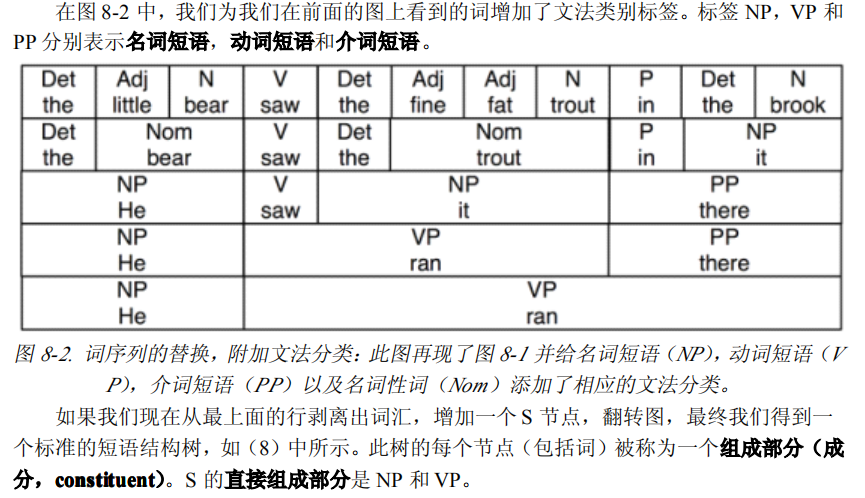

回到我们的表格表示，假设对于词an我们有Det在(2, 3)单元，对以词elephant有N在(3, 4)单元，对于an elephant我们应该在(2, 4)放入什么？我们需要找到一个形如A → Det N的产生式。

In [28]:
'''
程序使用此规则完成 WFST。
通 过调用函数 complete_wfst() 时设置 trace 为 True,
我们看到了显示 WFST 正在被创建 的跟踪输出:
'''
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar, trace=True)

[2] Det [3]   N [4] ==> [2]  NP [4]
[5] Det [6]   N [7] ==> [5]  NP [7]
[1]   V [2]  NP [4] ==> [1]  VP [4]
[4]   P [5]  NP [7] ==> [4]  PP [7]
[0]  NP [1]  VP [4] ==> [0]   S [4]
[1]  VP [4]  PP [7] ==> [1]  VP [7]
[0]  NP [1]  VP [7] ==> [0]   S [7]


WFST 有几个缺点。首先,正如你可以看到的,WFST 本身不是一个分析树,所以该技
术严格地说是认识到一个句子被一个文法承认,而不是分析它。其次,它要求每个非词汇文 法生产式是二元的。虽然可以将任意的 CFG 转换为这种形式,我们宁愿使用这种方法时没 有这样的规定。第三,作为一个自下而上的方法,它潜在的存在浪费,它会在不符合文法的 地方提出成分。

## 依存关系和依存文法
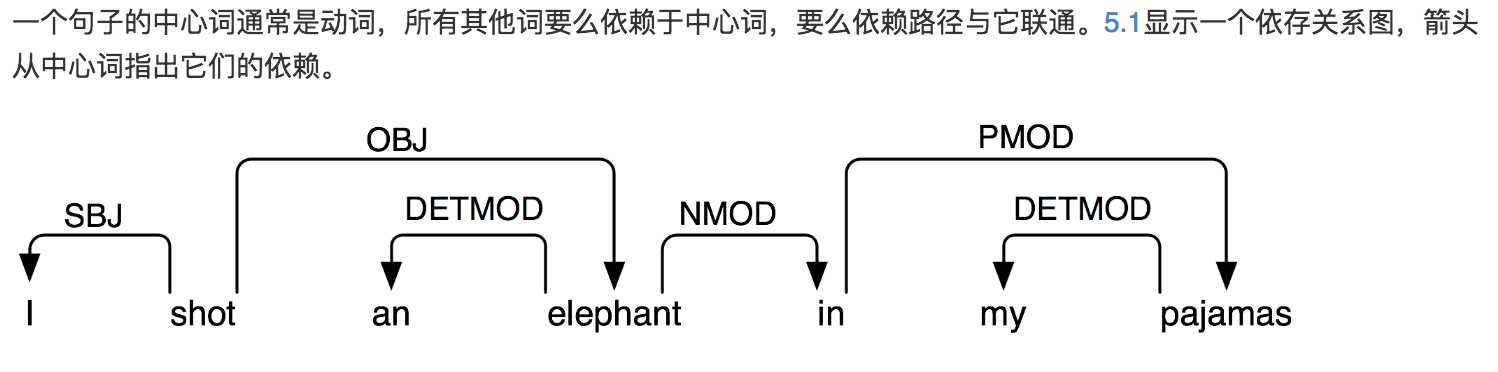

In [32]:
'''
下面是NLTK为依存语法编码的一种方式——注意它只能捕捉依存关系信息，不能指定依存关系类型

依存关系图是一个投影，当所有的词都按线性顺序书写，边可以在词上绘制而不会交叉。
这等于是说一个词及其所有后代依赖（依赖及其依赖的依赖，等等）在句子中形成一个连续的词序列。
'''
groucho_dep_grammar = nltk.DependencyGrammar.fromstring("""
 'shot' -> 'I' | 'elephant' | 'in'
 'elephant' -> 'an' | 'in'
 'in' -> 'pajamas'
 'pajamas' -> 'my'
 """)
print(groucho_dep_grammar)

Dependency grammar with 7 productions
  'shot' -> 'I'
  'shot' -> 'elephant'
  'shot' -> 'in'
  'elephant' -> 'an'
  'elephant' -> 'in'
  'in' -> 'pajamas'
  'pajamas' -> 'my'


In [ ]:
'''
我们可以使用投影依存关系分析器分析很多英语句子。
下面的例子演示groucho_dep_grammar如何提供了一种替代的方法来捕捉附着歧义
'''


In [33]:
>>> pdp = nltk.ProjectiveDependencyParser(groucho_dep_grammar)
>>> sent = 'I shot an elephant in my pajamas'.split()
>>> trees = pdp.parse(sent)
>>> for tree in trees:
...     print(tree)

(shot I (elephant an (in (pajamas my))))
(shot I (elephant an) (in (pajamas my)))


## 扩大规模

很难将语法模块化，每部分语法可以独立开发。反过来这意味着，在一个语言学家团队中分配编写语法的任务是很困难的。另一个困难是当语法扩展到包括更加广泛的成分时，适用于任何一个句子的分析的数量也相应增加。换句话说，歧义随着覆盖而增加。

尽管存在这些问题，一些大的合作项目在为几种语言开发基于规则的语法上已取得了积极的和令人印象深刻的结果。例如，词汇功能语法（LFG）Pargram 项目、中心词驱动短语结构文法（HPSG）LinGO 矩阵框架和词汇化树邻接语法XTAG项目。

## 语法开发
我们上面给出的所有例子只涉及玩具语法包含少数的产生式。如果我们尝试扩大这种方法的规模来处理现实的语言语料库会发生什么？在本节中，我们将看到如何访问树库，并看看开发广泛覆盖的语法的挑战。

In [34]:
#树库和语法
# corpus模块定义了treebank语料的阅读器
from nltk.corpus import treebank

In [36]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/zhengtao/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [37]:
t = treebank.parsed_sents('wsj_0001.mrg')[0]
print (t)

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


In [38]:
'''
利用这些数据来帮助开发一个语法。
语法为：VP -> Vs S的产生式，这个信息使我们能够识别那些包括在Vs的扩张中的特别的动词
'''
def filter(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return  (tree.label() == 'VP') and ('S' in child_nodes)

In [43]:
nltk.download('ppattach')

[nltk_data] Downloading package ppattach to
[nltk_data]     /Users/zhengtao/nltk_data...
[nltk_data]   Unzipping corpora/ppattach.zip.


True

In [44]:
[subtree for tree in treebank.parsed_sents()
         for subtree in tree.subtrees(filter)]

[Tree('VP', [Tree('VBN', ['named']), Tree('S', [Tree('NP-SBJ', [Tree('-NONE-', ['*-1'])]), Tree('NP-PRD', [Tree('NP', [Tree('DT', ['a']), Tree('JJ', ['nonexecutive']), Tree('NN', ['director'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('DT', ['this']), Tree('JJ', ['British']), Tree('JJ', ['industrial']), Tree('NN', ['conglomerate'])])])])])]),
 Tree('VP', [Tree('VBD', ['said']), Tree(',', [',']), Tree('``', ['``']), Tree('S', [Tree('NP-SBJ', [Tree('DT', ['This'])]), Tree('VP', [Tree('VBZ', ['is']), Tree('NP-PRD', [Tree('DT', ['an']), Tree('JJ', ['old']), Tree('NN', ['story'])])])])]),
 Tree('VP', [Tree('VBD', ['said']), Tree('S', [Tree('-NONE-', ['*T*-1'])])]),
 Tree('VP', [Tree('VBN', ['expected']), Tree('S', [Tree('-NONE-', ['*?*'])])]),
 Tree('VP', [Tree('VBD', ['said']), Tree('S', [Tree('-NONE-', ['*T*-1'])])]),
 Tree('VP', [Tree('VBZ', ['appears']), Tree('S', [Tree('NP-SBJ', [Tree('-NONE-', ['*-1'])]), Tree('VP', [Tree('TO', ['to']), Tree('VP', [Tree('VB', ['be']), Tree('

In [45]:
'''
PP附着语料库nltk.corpus.ppattach是另一个有关特别动词配价的信息源。
在这里，我们演示挖掘这个语料库的技术。
它找出具有固定的介词和名词的介词短语对，其中介词短语附着到VP还是NP，由选择的动词决定。
'''
from collections import defaultdict
entries = nltk.corpus.ppattach.attachments('training')
table = defaultdict(lambda: defaultdict(set))
for entry in entries:
    key = entry.noun1 + '-' + entry.prep + '-' + entry.noun2
    table[key][entry.attachment].add(entry.verb)
for key in sorted(table):
    if len(table[key]) > 1:
        print(key, 'N:', sorted(table[key]['N']), 'V:', sorted(table[key]['V']))

%-below-level N: [u'left'] V: [u'be']
%-from-year N: [u'was'] V: [u'declined', u'dropped', u'fell', u'grew', u'increased', u'plunged', u'rose', u'was']
%-in-August N: [u'was'] V: [u'climbed', u'fell', u'leaping', u'rising', u'rose']
%-in-September N: [u'increased'] V: [u'climbed', u'declined', u'dropped', u'edged', u'fell', u'grew', u'plunged', u'rose', u'slipped']
%-in-week N: [u'declined'] V: [u'was']
%-to-% N: [u'add', u'added', u'backed', u'be', u'cut', u'go', u'grow', u'increased', u'increasing', u'is', u'offer', u'plummet', u'reduce', u'rejected', u'rise', u'risen', u'shaved', u'wants', u'yield', u'zapping'] V: [u'fell', u'rise', u'slipped']
%-to-million N: [u'declining'] V: [u'advanced', u'climbed', u'cutting', u'declined', u'declining', u'dived', u'dropped', u'edged', u'fell', u'gained', u'grew', u'increased', u'jump', u'jumped', u'plunged', u'rising', u'rose', u'slid', u'slipped', u'soared', u'tumbled']
1-to-21 N: [u'dropped'] V: [u'dropped']
1-to-33 N: [u'gained'] V: [u'dropp

In [47]:
nltk.download('sinica_treebank')

[nltk_data] Downloading package sinica_treebank to
[nltk_data]     /Users/zhengtao/nltk_data...
[nltk_data]   Unzipping corpora/sinica_treebank.zip.


True

In [48]:
nltk.corpus.sinica_treebank.parsed_sents()[3450].draw()

## 概率上下文无关语法（或PCFG）
它的每一个产生式关联一个概率。它会产生与相应的上下文无关语法相同的文本解析，并给每个解析分配一个概率。PCFG产生的一个解析的概率仅仅是它用到的产生式的概率的乘积。

最简单的方法定义一个PCFG 是从一个加权产生式序列组成的特殊格式的字符串加载它，其中权值出现在括号里

In [51]:
grammar = nltk.PCFG.fromstring("""
    S    -> NP VP              [1.0]
    VP   -> TV NP              [0.4]
    VP   -> IV                 [0.3]
    VP   -> DatV NP NP         [0.3]
    TV   -> 'saw'              [1.0]
    IV   -> 'ate'              [1.0]
    DatV -> 'gave'             [1.0]
    NP   -> 'telescopes'       [0.8]
    NP   -> 'Jack'             [0.2]
    """)

In [52]:
'''
有时可以很方便的将多个产生式组合成一行，
如VP -> TV NP [0.4] | IV [0.3] | DatV NP NP [0.3]。
为了确保由文法生成的树能形成概率分布，PCFG语法强加了约束，
产生式所有给定的左侧的概率之和必须为1。
6.4中的语法符合这个约束：对S只有一个产生式，它的概率是1.0；
对于VP，0.4+0.3+0.3=1.0；对于NP，0.8+0.2=1.0。parse()返回的分析树包含概率：
'''
viterbi_parser = nltk.ViterbiParser(grammar)
for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']):
    print(tree)

(S (NP Jack) (VP (TV saw) (NP telescopes))) (p=0.064)
